# Trabjo Práctico Integrador: GRUPO 8
## Autores:

- Choconi Lucas
- Berra Eliel
- Mina Federico
- Scillato German

<a id="section_toc"></a> 
## INDICE

[Importaciones - Configuración](#section_Import)

$\hspace{.5cm}$[Configuracion](#section_config)

[Logica de Desarrollo](#section_logica)

[Análisis y Limpieza de datos](#section_limpieza)

$\hspace{.5cm}$[AGREGAR TITUTLO](#section_dict)

$\hspace{.5cm}$[Análisis Exploratorio](#section_dict)

$\hspace{.5cm}$[Definicion Porter y función Tokenizer](#section_sinstop)  

$\hspace{.5cm}$[Influencia Stopwords](#section_sinstop)


[Pre-Procesamiento](#section_prepros)


[Problema](#section_problema)

[GroupBy](#section_groupby)

[Agregaciones simples](#section_agregaciones_simples)

[¿Cómo construimos grupos?](#section_construccion_grupos)

$\hspace{.5cm}$[DataFrameGroupBy](#section_dataframegroupby)

<a id="section_Import"></a>  
## Importaciones y configuración

In [38]:
import os
from os import path
import time
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import requests
import warnings

from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm

from lime.lime_tabular import LimeTabularExplainer

from xgboost import XGBClassifier

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

import pickle

warnings.filterwarnings('ignore')

<a id="section_config"></a>  
#### Configuración Gráficos y Path

In [39]:
# Configuración Graficos 

myColors = ((0.90, 0.96, 1, 1), (0.70, 0.87, 1, 1), (0, 0.40, 0.75, 0.88))
cmap = LinearSegmentedColormap.from_list('Custom', myColors,10)

# Fuente de titulos de gráficos
font = {'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

# Función para graficos de WorldCloud

def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    """Argumentos de función necesarias para metodo worldcloud"""
    blues = "hsl(215,100%%, %d%%)" % np.random.choice(np.arange(25, 65, 5, dtype=int))
    reds = "hsl(0,100%%, %d%%)" % np.random.choice(np.arange(40, 80, 5, dtype=int))
    choice = np.random.choice([0, 1])
    if choice == 0:
        return blues
    else:
        return reds


def graficos_manos(fake,true):
    """Función para graficar worldcloud en forma de manos,
    falsas y verdaderas. Variables: worldcloud falsa y verdadera"""
    fig, axs = plt.subplots(1, 2,figsize=(20,10))  

    axs[1].imshow(fake.recolor(color_func=blue_color_func, random_state=3),
                interpolation="bilinear")
    axs[1].axis("off")
    axs[1].set_title('FAKE' , fontdict = font)
    axs[0].imshow(true.recolor(color_func=blue_color_func,random_state=3),
                interpolation="bilinear")
    axs[0].axis("off")
    axs[0].set_title('TRUE' , fontdict = font)
    plt.show()


In [40]:
# Importación de imagenes para graficos de manos.

mask_pos = np.array(Image.open("./data/Thumbs.png"))
mask_neg = np.array(Image.open("./data/Thumbsdw.png"))

<a id="section_logica"></a>  

### LOGICA DE DESARROLLO DEL MODELO
Se busco el conjunto de stopwords siguiendo el siguiente esquema

![Diagrama](./data/fake_d.png)

<a id="section_limpieza"></a>

## Limpieza de datos
Importación y limpieza del 
[Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

In [41]:
# El dataset vino separado en las noticias Falsas y Verdaderas, así que se lo unifica con append 
# entre los archivos True.csv y Fake.csv

file_names_true = pd.read_csv('./data/True.csv')
file_names_true['real'] = 'True'
file_names_fake = pd.read_csv('./data/Fake.csv')
file_names_fake['real'] = 'Fake'
data = file_names_fake.append(file_names_true, ignore_index=True)
data.head(2)

,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake


In [42]:
# Unimos el título y el contenido del artículo en una sola columna
data['text'] = data['title'] + ' --- ' + data['text'] 

# Ejemplo de 1 texto del dataset.
with pd.option_context('display.max_colwidth', None):
  print(data.head(1))
data = data.drop(columns = 'title')

                                                                             title  \
0   Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [43]:
# Algunas filas contienen datos erróneos que impiden transformar la columna 'date' a formato fecha
wrong_row = data['date'] == 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
data[wrong_row]

,text,subject,date,real
9358,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,Fake


In [44]:
# Las filas que no pueden ser correctamente transformadas a datetime
# serán utilizadas en una máscara booleana para poder eliminarlas

data['date'] = data['date'].apply(lambda x: pd.to_datetime(x,
                                                    infer_datetime_format = True)\
                                                    if re.search('[a-z-A-Z]+ [0-9]+, [0-9]{4}', x) else  np.NaN)
delete_mask = data['date'].notna()
data = data[delete_mask]
data = data.reset_index()
data['date'] = data['date'].astype('datetime64')

In [45]:
# Separamos los datos en dos máscaras con las filas que contienen noticias falsas de las que son reales
data_real = data[data['real'] == 'True']
data_fake = data[data['real'] == 'Fake']

# VALIDAR CON ELIEL O BORRAR

<a id="section_dict"></a>  
## TITULO DE LA SECCION, agregra

In [46]:
# Tarda mucho en ejecutarse esto, para el viernes lo subo, va a aportar al análisis estadístico incial

In [47]:
'''
# Averiguamos cuál es el largo promedio de las noticias falsas y de las reales

data['text_len'] = data['text'].apply(lambda x: len(word_tokenize(x)))

# Gráfico comparativo del largo promedio de las noticias falsas y verdaderas
real_len_avg = data_real['text_len'].mean()
fake_len_avg = data_fake['text_len'].mean()
len_avgs = [real_len_avg, fake_len_avg]
plt.bar(['Real', 'Fake'], len_avgs)

# Lista con todas las palabras en inglés https://github.com/dwyl/english-words/blob/master/words.txt
all_eng_words = pd.read_csv('./data/all_english_words.csv')
all_eng_words = pd.Series(all_eng_words.iloc[:,0])
all_eng_words = all_eng_words.apply(lambda x: x.lower() if type(x) == str else x)

def words_percentage(text):
    # Devuelve el porcentaje de palabras que posee un texto que están dentro de un diccionario
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words] 
    words_in_dict = [word for word in words if word in all_eng_words.values]
    words_in_dict_percentage = len(words_in_dict) * 100 / len(words)
    return words_in_dict_percentage

tqdm.pandas()
data['words_in_dict_pct'] = data['text'].progress_apply(words_percentage)

new_dataset_location = './data/data_with_pct'
data.to_csv(new_dataset_location, index = False)

data2 = pd.read_csv(new_dataset_location)
data2
'''


"\n# Averiguamos cuál es el largo promedio de las noticias falsas y de las reales\n\ndata['text_len'] = data['text'].apply(lambda x: len(word_tokenize(x)))\n\n# Gráfico comparativo del largo promedio de las noticias falsas y verdaderas\nreal_len_avg = data_real['text_len'].mean()\nfake_len_avg = data_fake['text_len'].mean()\nlen_avgs = [real_len_avg, fake_len_avg]\nplt.bar(['Real', 'Fake'], len_avgs)\n\n# Lista con todas las palabras en inglés https://github.com/dwyl/english-words/blob/master/words.txt\nall_eng_words = pd.read_csv('./data/all_english_words.csv')\nall_eng_words = pd.Series(all_eng_words.iloc[:,0])\nall_eng_words = all_eng_words.apply(lambda x: x.lower() if type(x) == str else x)\n\ndef words_percentage(text):\n    # Devuelve el porcentaje de palabras que posee un texto que están dentro de un diccionario\n    words = word_tokenize(text)\n    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words] \n    words_in_dict = [word for word in words if word in all_eng_word

<a id="section_EDA"></a>  

### Analisis Exploratorio del Dataset

<Figure size 1440x432 with 0 Axes>

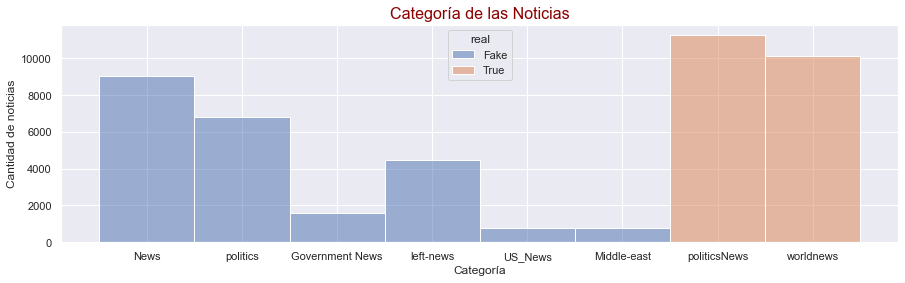

<Figure size 1440x432 with 0 Axes>

In [48]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.histplot(data = data, x = 'subject', hue = 'real' )
plt.ylabel('Cantidad de noticias')
plt.xlabel('Categoría')
plt.title("Categoría de las Noticias", fontdict= font)
plt.figure(figsize=(20,6))

In [49]:
# Como hay valores diferentes en la columna "subject" para las noticias reales y las falsas borramos esa columna
data = data.drop(columns = 'subject')

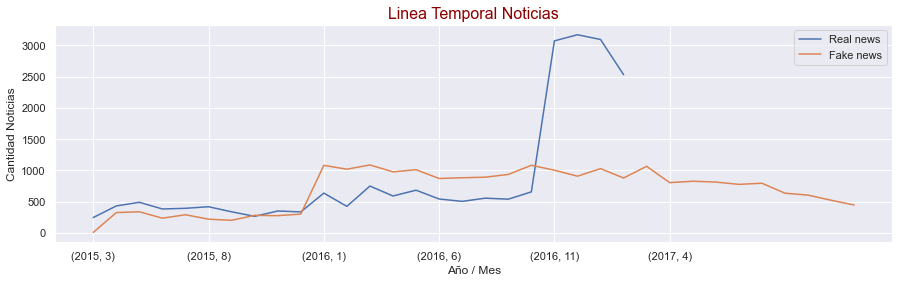

In [50]:
# Hacemos un gráfico mostrando el conteo de cuántas noticias falsas y cuántas verdaderas se publicaron 
# por mes en el dataset 
ax = data_real['date'].groupby([data_real["date"].dt.year,
                             data_real["date"].dt.month]).count().plot.line(label = 'Real news')

ax = data_fake['date'].groupby([data_fake["date"].dt.year,
                            data_fake["date"].dt.month]).count().plot.line(label = 'Fake news')
ax.set(xlabel=None)
ax.set_title('Linea Temporal Noticias' , fontdict = font)
ax.set_xlabel('Año / Mes')
ax.set_ylabel('Cantidad Noticias')
ax.legend()

El pico de noticias verdaderas publicadas en Noviembre del 2016 coincide con las elecciones presidenciales de Estados Unidos

Se verifica limpieza de dataset

In [51]:
# El dataset no valores nulos así que damos por finalizada la limpieza
print(data.isna().sum())

index    0
text     0
date     0
real     0
dtype: int64


In [52]:
stopwords_en = stopwords.words('english')


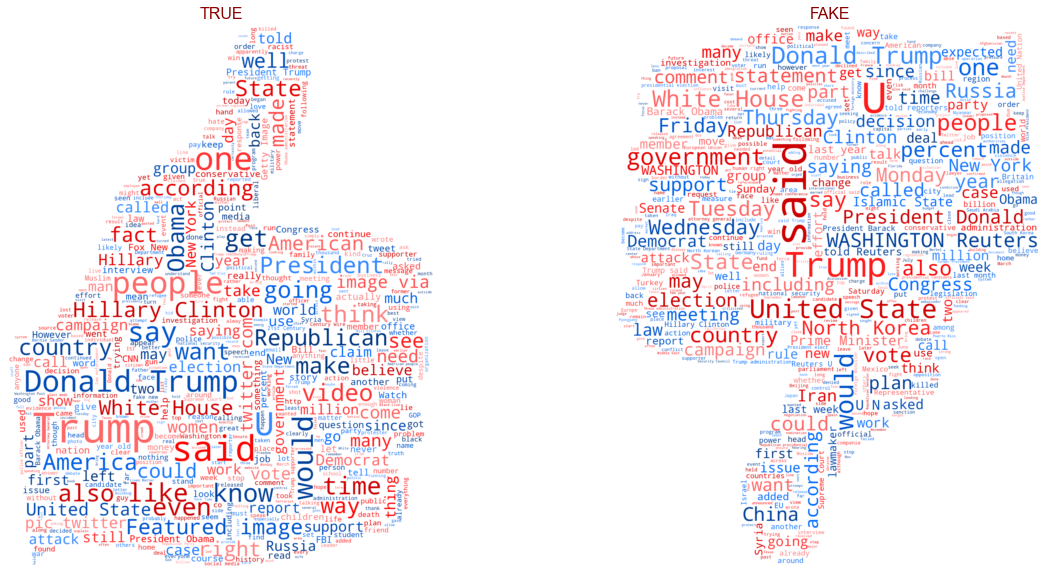

In [53]:
# Generamos un gráfico que muestra visualmente las palabras que más frecuentemente aparecen tanto en noticias
# falsas como verdaderas

wordcloud_fake = WordCloud(stopwords=stopwords_en,
            mask=mask_neg, 
            max_words=500,
            background_color="white").generate(data_real.text.str.cat(sep=' '))
wordcloud_true = WordCloud(stopwords=stopwords_en,
            mask=mask_pos,
            max_words=500,
            background_color="white").generate(data_fake.text.str.cat(sep=' '))


graficos_manos(fake = wordcloud_fake,true = wordcloud_true)

<a id="section_porter"></a>  
### Definición de porter y función tokenizer
Se define el porter y la función para luego aplicar en el método countvectorizer para el resto de la notebook. Tener en cuenta que la variable global que cambia es   **stopwords_en**

In [54]:
# Se utiliza este stemmer por default, y al obtenerse buenos resultados iniciales, se continua trabajando
# en el análisis de las features importance. 
# La variable stopwords_en ya se encuentra definida en la sección de Análisis exploratorio.
# porter queda definido para las secciones siguientes
porter = PorterStemmer()
stopwords_en_porter = [porter.stem(x) for x in stopwords_en]

In [55]:
# Definición de función para el tokenizer
def porter_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso
    de tokenización en la clase CountVectorizer para que se pueda
     obtener también la raíz de la palabra con el método Porter.'''
    porter = PorterStemmer()
    stopwords_en_porter = [porter.stem(x) for x in stopwords_en]
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [porter.stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_porter] # remover las stopwords
    return words

<a id="section_sinstop"></a>  
#### Influencia de stopwords
En esta sección se analiza el sobreajuste para el dataset inicial, si no se retira las stopwords definidas. A continuación se muestra los resultados del modelo incluyendo dichas palabras. Se utiliza el modelo de "Tree" como ejemplo.

Se consideran los siguientes puntos para esta sección
- Se utiliza un sample de 1000 datos para evaluar la influencia de stopwords.
- Se utiliza un modelo simple de tree, con tendencia a sobreajuste.
- En las secciones siguientes se vuelve a definir los X_train, X_test , y_train e y_test.

In [56]:
# Se redefine x_train y x_test

testing_sample_size = 1000 # Algunas operaciones se demoran mucho tiempo, tamaño pequeño es para agilizarlas

data_sample = data.sample(testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train_completo, X_test_completo, y_train_completo, y_test_completo = train_test_split(X, y, test_size = 0.3)

In [57]:
# Se define stopwords y se genera nuevamente la vectorización, y la matriz tfidf

stopwords_en_porter = [porter.stem(x) for x in stopwords_en]
customized_vectorizer_feature= CountVectorizer(lowercase = True,
                                               strip_accents='unicode', 
                                               tokenizer = porter_tokenizer,
                                               ngram_range = (1, 3),
                                               min_df = 3)

customized_vectorizer_matrix = customized_vectorizer_feature.fit_transform(X_train_completo)
customized_vectorizer_test = customized_vectorizer_feature.transform(X_test_completo)

In [58]:
tfidf_matrix_train_completo = TfidfTransformer().fit_transform(customized_vectorizer_matrix)
tfidf_matrix_test_completo = TfidfTransformer().fit_transform(customized_vectorizer_test) 

X_train_completo= tfidf_matrix_train_completo
X_test_completo = tfidf_matrix_test_completo

In [59]:
# Modelo ejemplo para mostrar sobre ajuste.
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train_completo , y_train_completo )
print("Score modelo con stopwords: ", round(my_tree.score(X_test_completo ,
                                            y_test_completo )))

Score modelo con stopwords:  1


<Figure size 1440x432 with 0 Axes>

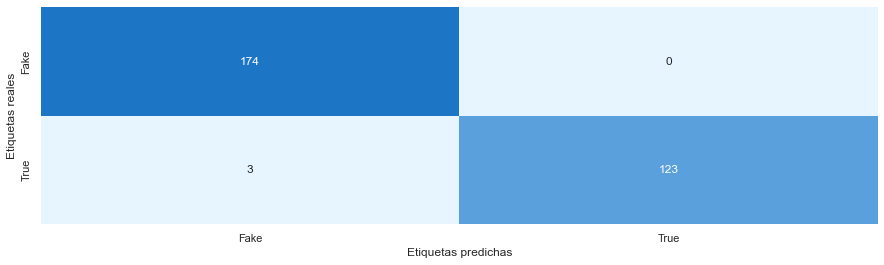

<Figure size 1440x432 with 0 Axes>

In [60]:
cm_tree = confusion_matrix(y_test_completo , my_tree.predict(X_test_completo ))

axis_labels = np.sort(y_test_completo.unique())
sns.heatmap(cm_tree, xticklabels=axis_labels,yticklabels=axis_labels,
             cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');
plt.figure(figsize=(20,6))

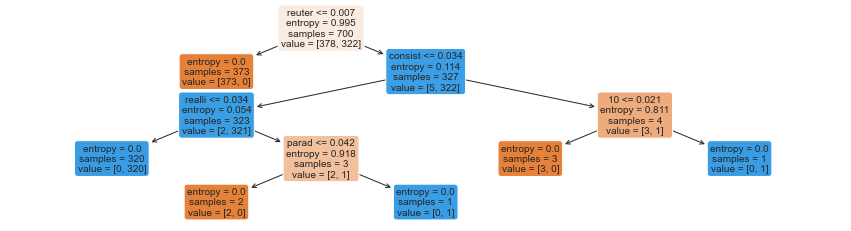

In [61]:
tree.plot_tree(my_tree,feature_names = customized_vectorizer_feature.get_feature_names(),
                filled=True,rounded=True, fontsize = 10)
plt.show()

<a id="section_prepros"></a>  

## Pre-procesamiento

A partir del wordcloud se analiza el Dataset y se verifica inicialmente posible palabras a descartar

Se divide el dataset en train y test. 

In [62]:
# Algunas operaciones se demoran mucho tiempo debido a la gran cantidad de columnas que se generan al vectorizar
# los datos, el tamaño pequeño de la muestra es para agilizar las operaciones
testing_sample_size = 2000 
small_testing_sample_size = 100 # Para hacer testeos aún más rápidos se recomienda este sampleo 
data_sample = data.sample(small_testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Para obtener la raiz de las palabras se utiliza [Porter Stemmer](https://www.nltk.org/_modules/nltk/stem/porter.html)

In [63]:
# Agrego Stopwords específicas del dataset.

def append_stopword(listado_stopwords, stopwords_agregar):
    for stopwords in stopwords_agregar:
        listado_stopwords.append(stopwords)
    return listado_stopwords

stopwords_agregar = ['reuter','said','Reuters','via','imag','https','com','one',
'u','also','would','featur','pic','us','wednesday','friday','monday','tuesday',
'saturday','sunday','thursday','getti','read','gop','watch','donald','trump',
'hillari','mr','accord','america','seem','youtub','21st',
'video' , 'http' , 'like' , 'obama' , 'minist' , 'washington' , 'know' , ]

stopwords_en = append_stopword(stopwords_en_porter ,stopwords_agregar )

In [64]:
# Agregar a utils

In [65]:
# Definición de función para el tokenizer con Lancaster Stemmer que será utilizado en el pipeline
def lancaster_tokenizer(text):
    ''' Esta función se utiliza cuando se sobre escribe el proceso
    de tokenización en la clase CountVectorizer para que se pueda
     obtener también la raíz de la palabra con el ḿetodo Lancaster.'''
    lancaster = LancasterStemmer()
    stopwords_en_lancaster = [lancaster.stem(x) for x in stopwords_en]
    words = word_tokenize(text)
    words = [re.sub('[^A-Za-z0-9]+', '', word) for word in words]  # remover los caracteres especiales
    words = [word.replace(' ', '') for word in words] #remover los espacios en blanco
    words = [word for word in words if word != '']
    words = [lancaster.stem(word) for word in words] # obtener la raiz de las palabras
    words = [word for word in words if word not in stopwords_en_lancaster] # remover las stopwords
    return words

In [66]:
# La ventaja de este CountVectorizer es que incluye una función porter_tokenizer como parámetro que permite
# customizar el procedimiento para obtener la raíz de la palabra
customized_vectorizer= CountVectorizer(lowercase = True,
                                       strip_accents='unicode', 
                                       tokenizer = porter_tokenizer,
                                       ngram_range = (1, 3),
                                       min_df = 3)

customized_vectorizer_train = customized_vectorizer.fit_transform(X_train)
customized_vectorizer_test = customized_vectorizer.transform(X_test)

In [67]:
# Construcción de matrices tfidf
tfidf_matrix_train = TfidfTransformer().fit_transform(customized_vectorizer_train)
tfidf_matrix_test = TfidfTransformer().fit_transform(customized_vectorizer_test) 

### Cambio de Base

##### Evaluación del impacto con distintas cantidades de componentes

In [68]:
# modificar función para que no grafique 2 veces con parámetro booleano

In [69]:
# Definición de función para cambio de base

def select_n_components(var_ratio, goal_var: float) -> int: 
    ''' Esta función se utiliza para hacer un cambio de base y lograr explicar
    el porcentaje de los datos que se pasa en el argumento goal_var.
    Fuente https://chrisalbon.com/code/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
    Fue modificada para que hiciera un gráfico de la varianza explicativa del
    modelo de acuerdo al número de componentes'''
    # Set initial variance explained so far
    total_variance = 0.0
    # Set initial number of features
    n_components = 0
    # Listas del nuḿero de componentes y de la explicación de varianza alcanzada para poder graficarlas
    num_components = list(range(1, len(var_ratio) + 1))
    variances = []
    # For the explained variance of each feature:
    found_n_components = False
    for explained_variance in var_ratio:
        # Add the explained variance to the total
        total_variance += explained_variance
        # Add one to the number of components
        n_components += 1
        # Agregar la varianza explicada al listado 
        variances.append(total_variance)
        # If we reach our goal level of explained variance and we haven't reached our desired variance
        if total_variance >= goal_var and found_n_components == False:
            desired_n_components = n_components
            found_n_components = True
            desired_variance = total_variance
    plt.plot(num_components, variances )
    plt.scatter(desired_n_components, desired_variance, c = 'r')
    plt.xlabel('Número de componentes')
    plt.ylabel('Razón de la explicación de la varianza')
    plt.hlines(desired_variance, 0, desired_n_components, 'r', 'dashed')
    plt.vlines(desired_n_components, 0, desired_variance, 'r', 'dashed')
    plt.title("Comparativa Varianza vs Número componentes ",fontdict=font)
        
    # Return the desired number of components. 
    # Tipo de variable devuelta definido por " -> int " PEP3107
    return desired_n_components

Para Threshold 0.9 número de componentes después del cambio de base: 58
Para Threshold 0.5 número de componentes después del cambio de base: 25
Para Threshold 0.1 número de componentes después del cambio de base: 4


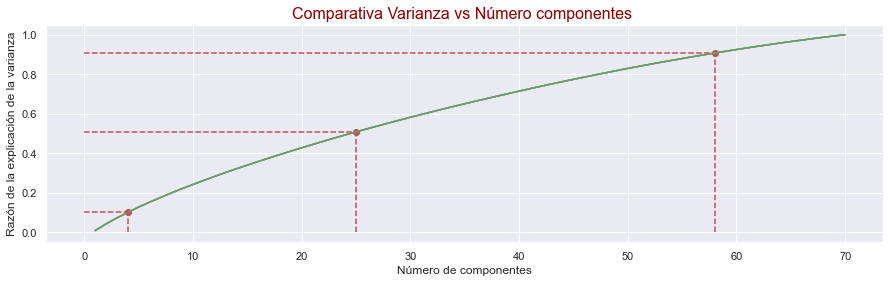

In [70]:
# Evaluación de cambio de base para 3 threshold
# Evaluamos cómo responde el cambio de base cuando seleccionamos una explicación
# de la varianza alta (0.9), media (0.5) o baja (0.1)
desired_threshold = [0.9 , 0.5 , 0.1]


# Tener en cuenta que si el número de filas de la matrix esparsa es menor al número de componentes elegido
# como hiperparámetro, una vez que se haya realizado la transformación SVD el número de componentes 
# obtenido será igual al número de filas de la matriz esparsa, y no será el número de componentes
# elegido como hiperpárametro
for thres in desired_threshold:
    test_svd = TruncatedSVD(n_components = tfidf_matrix_train.shape[1] - 1);
    test_svd.fit(tfidf_matrix_train)
    tsvd_var_ratios = test_svd.explained_variance_ratio_
    desired_threshold = thres
    n_components = select_n_components(tsvd_var_ratios, desired_threshold)

    print(f'Para Threshold {thres} número de componentes después del cambio de base: {n_components}')

##### Aplicacion SVD

Se concluye que se tiene una performance aceptable aunque solo se capture el 10% de la varianza del dataset. Por lo cual, en el pipeline se incluiran los 3 threshold.

## Feature Selection
Esta etapa de la construcción del modelo, se hizo de forma iterativa, verificando palabras que no tuvieran sentido real en la predicción de noticias falsas

In [71]:
# Se realiza la vectorización con el dataset completo.
customized_vectorizer_feature= CountVectorizer(lowercase = True,
                                        strip_accents='unicode', 
                                        tokenizer = porter_tokenizer,
                                        ngram_range = (1, 3),
                                        min_df = 0.002,
                                        max_df= 0.9)

customized_vectorizer_feature.fit(data.text)
customized_vectorizer_matrix = customized_vectorizer_feature.transform(data.text)

In [ ]:
tfidf_matrix_feature = TfidfTransformer().fit_transform(customized_vectorizer_matrix)

In [ ]:
# Definición de modelo Tree para evaluar peso de cada palabra.
dt = tree.DecisionTreeClassifier(criterion='gini',
max_depth=4,min_samples_leaf=2)
dt.fit(tfidf_matrix_feature, data_sample["real"])
importancia_features = pd.DataFrame(dt.feature_importances_,
 index = customized_vectorizer_feature.get_feature_names(),
 columns=['importancia'])
importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)
print(importancia_features_sort[0:10])

# Modelos

In [ ]:
X_train = tfidf_matrix_train
X_test = tfidf_matrix_test

In [ ]:
# Podemos poner un mini gráfico mostrando el balanceo de la target para ver contra qué se está comparando 
# el accuracy

## Naive Bayes

In [ ]:
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
NB_model.score(X_test, y_test)

In [ ]:
axis_labels = np.sort(y_test.unique())
cm_nb = confusion_matrix(y_test, NB_model.predict(X_test))
sns.heatmap(cm_nb, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

#### Modelo de Reg. Logistica

In [ ]:
reg_model = LogisticRegression(C = 7, solver="saga", l1_ratio=0.5 ,
                                 penalty="elasticnet", n_jobs=-1)
reg_model.fit(X_train, y_train)
reg_model.score(X_test, y_test)

In [ ]:
cm_rlog = confusion_matrix(y_test, reg_model.predict(X_test))
sns.heatmap(cm_rlog, xticklabels=axis_labels, yticklabels=axis_labels,
             cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

In [ ]:
Coef_reg_model = pd.DataFrame(np.transpose(reg_model.coef_), index=customized_vectorizer.get_feature_names(),
 columns=['Coef'])
Coef_reg_model['coef_abs'] = abs(Coef_reg_model['Coef'])
Coef_reg_model = Coef_reg_model.reset_index(-1)
Coef_reg_model['words'] = Coef_reg_model['index'] 
Coef_reg_model['freq'] = (round(Coef_reg_model['coef_abs'] / Coef_reg_model.coef_abs.sum()* Coef_reg_model.shape[0] * 1000 , 0)).apply(lambda x: int(x))
Coef_reg_model['odds_direction'] = Coef_reg_model['Coef'].apply(lambda x: 'Negative' if x<0 else 'Positive')

Coef_reg_model_positive = Coef_reg_model[Coef_reg_model['odds_direction']=='Positive']
Coef_reg_model_positive = Coef_reg_model_positive.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)
Coef_reg_model_negative = Coef_reg_model[Coef_reg_model['odds_direction']=='Negative']
Coef_reg_model_negative = Coef_reg_model_negative.drop(['Coef' ,'coef_abs', 'index', 'odds_direction'], axis=1)

In [ ]:
tuples_pos = Coef_reg_model_positive.set_index('words').T.to_dict('index')
tuples_neg = Coef_reg_model_negative.set_index('words').T.to_dict('index')

wordcloud_positive = WordCloud(max_words=500, mask=mask_pos,
        background_color="white").generate_from_frequencies(dict(tuples_pos['freq']))
wordcloud_negative = WordCloud(max_words=500, mask=mask_neg,
        background_color="white").generate_from_frequencies(dict(tuples_neg['freq']))

graficos_manos(fake = wordcloud_fake,true = wordcloud_true)

## Modelo de Reg. Logistica Truncando palabras

In [ ]:
test_svd = TruncatedSVD(n_components = X_train.shape[1] - 1);
test_svd.fit(X_train)
tsvd_var_ratios = test_svd.explained_variance_ratio_
desired_threshold_90 = 0.90
desired_threshold_50 = 0.50
desired_threshold_10 = 0.10
n_components_90 = select_n_components(tsvd_var_ratios, desired_threshold_90)
n_components_50 = select_n_components(tsvd_var_ratios, desired_threshold_50)
n_components_10 = select_n_components(tsvd_var_ratios, desired_threshold_10)


In [ ]:
svd_90 = TruncatedSVD(n_components = n_components_90)
svd_50 = TruncatedSVD(n_components = n_components_50)
svd_10 = TruncatedSVD(n_components = n_components_10)

X_train_svd_90 = svd_90.fit_transform(X_train)
X_test_svd_90 = svd_90.transform(X_test)
X_train_svd_50 = svd_50.fit_transform(X_train)
X_test_svd_50 = svd_50.transform(X_test)
X_train_svd_10 = svd_10.fit_transform(X_train)
X_test_svd_10 = svd_10.transform(X_test)

In [ ]:
X_svd = [[X_train_svd_90,X_test_svd_90],[X_train_svd_50,X_test_svd_50],[X_train_svd_10,X_test_svd_10]]
scores = []
models = []
for svd in X_svd:

    reg_model_svd = LogisticRegression(C = 8, solver="newton-cg", penalty="l2")
    models.append(reg_model_svd.fit(svd[0], y_train))
    scores.append(reg_model_svd.score(svd[1], y_test))

In [ ]:
figs, axs = plt.subplots(1,3, figsize= (15,5))
title = [90,50,10]
for i in range(3):
    
    cm_rlog_svd = confusion_matrix(y_test, models[i].predict(X_svd[i][1]))
    sns.heatmap(cm_rlog_svd,xticklabels=axis_labels, yticklabels=axis_labels,
                cbar=False, annot=True, cmap=cmap, fmt='d', ax = axs[i],
                linecolor = "w" , linewidths = .5,square=True)
    axs[i].set_title(label = f'SVD Threshold {title[i]}' , 
    loc ='left', fontdict = font )
    axs[0].set_ylabel('Etiquetas reales')
    axs[i].set_xlabel('Etiquetas predichas')

## Decision Tree Classifier

In [ ]:
my_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
my_tree.fit(X_train, y_train)
my_tree.score(X_test, y_test)

In [ ]:
cm_tree = confusion_matrix(y_test, my_tree.predict(X_test))
sns.heatmap(cm_tree, xticklabels=axis_labels, yticklabels=axis_labels,
            cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

In [ ]:
plt.figure(figsize=(20,6))
tree.plot_tree(my_tree,feature_names = customized_vectorizer.get_feature_names(),
                filled=True,rounded=True, fontsize = 10)
plt.show()

## Boosting de Modelos

In [ ]:
base_classifier = ExtraTreesClassifier(n_estimators=100, 
                                      criterion='gini', 
                                      max_depth = 4, 
                                      bootstrap=True, 
                                      n_jobs = -1, 
                                      random_state = 127,
                                      max_samples= 0.3)

boost_tree = AdaBoostClassifier(base_estimator = base_classifier, 
                            n_estimators = 200,
                            learning_rate = 0.8,                                       
                            random_state = 127)

boost_tree.fit(X_train, y_train) 
boost_tree.score(X_test, y_test)

In [ ]:
cm_boost_tree = confusion_matrix(y_test, boost_tree.predict(X_test))
sns.heatmap(cm_boost_tree, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')

## Evaluación de los modelos - ROC CURVE  

In [ ]:
"""# Calculo de probabilidad de los distintos modelos
y_pred_boost = boost_tree.predict_proba(X_test)
y_pred_my_tree = my_tree.predict_proba(X_test)
y_pred_reg_model = reg_model.predict_proba(X_test)
y_pred_NB = NB_model.predict_proba(X_test)

models = models.append(boost_tree,)"""

In [ ]:
"""def ROC_curve(modelos, X_test , y_test):
    "Calcula las probabilidades y grafica la ROC Curve de los modelos
    en lista 'Modelos'. "
    for model in modelos:
        y_pred_proba = model.predict_proba(X_test)
        fpr_log, tpr_log, thr_log = roc_curve(y_test, y_pred_proba[:,1])
        df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
        plt.plot(df['fpr'],df['tpr'], label='Modelo')
    
    plt.axis([0, 1.01, 0, 1.01]); plt.legend()
    plt.xlabel('1 - Specificty'); plt.ylabel('TPR / Sensitivity'); plt.title('ROC Curve')
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show()

ROC_curve(modelos = models, X_test = X_test , y_test = y_test)"""

In [ ]:
# ESTO LO AGREGAMOS?

In [ ]:
"""X_train_dense = pd.DataFrame(X_train.todense(), columns=count_vectorizer.get_feature_names_out())
X_train_explainer = np.array(X_train_dense)
explainer = LimeTabularExplainer(X_train_explainer, 
                                 mode = "classification",
                                 training_labels = y_train,
                                 feature_names = count_vectorizer.get_feature_names_out(),
                                 discretize_continuous=False)"""

In [ ]:
"""data_row = np.array(X_test[0].todense())[0]

explanation = explainer.explain_instance(data_row, reg_model.predict_proba, num_features=10)
explanation.as_pyplot_figure()"""

In [ ]:
# Podríamos agregar alguna conclusión de los modelos que fuimos probando, podemos agregar un gráfico
# comparando los accuracy

## Pipeline

In [ ]:
# Estamos repitiendo de nuevo el sampleo de los datos

In [ ]:
testing_sample_size = 100 # Algunas operaciones se demoran mucho tiempo, tamaño pequeño es para agilizarlas

data_sample = data.sample(testing_sample_size)
X = data_sample['text']
y = data_sample['real']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [ ]:
pasos = [('vectorizador', CountVectorizer()),
         ('tfidf', TfidfTransformer()), 
         ('cambio_base', TruncatedSVD()),
         ('modelo', LogisticRegression())]
pipeline = Pipeline(pasos)

In [ ]:
# clase para generar cambios de base con diferente número de componentes
class SVD_n_components(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X, y):
        return self
    
    def transform(self, X, y):
        svd = TruncatedSVD(n_components = self.n_components);
        return svd.fit_transform(X, y)

    
# BORRAR CUANDO FINALIZAN PRUEBAS
#n_components_90 = 10
#n_components_50 = 11
#n_components_10 = 12

In [ ]:
# Ojo con meter un adaboost vacío y el número de estimators q no se vaya al carajo

In [ ]:
param_grid = [{ 'vectorizador__lowercase': [True],
                'vectorizador__strip_accents': ['unicode'],   
                'vectorizador__ngram_range': [(1, 4), (2, 4)],
                'vectorizador__max_df': [0.95, 1],
                'vectorizador__min_df': [0.001, 0.02],
                'vectorizador__tokenizer': [porter_tokenizer, lancaster_tokenizer],
                'tfidf__norm': ['l1', 'l2'],
                'cambio_base': [SVD_n_components(n_components_10),
                                SVD_n_components(n_components_50),
                                SVD_n_components(n_components_90),
                                None],
               'modelo': [AdaBoostClassifier(), LogisticRegression()],
                #ExtraTreesClassifier() , ()]
               }]

In [ ]:
# Apróximadamente toma 10 min la ejecución con un sample de 1000 records y param_grid2
folds=StratifiedKFold(n_splits=5,shuffle=True)
grid = GridSearchCV(estimator = pipeline,param_grid = param_grid, cv = folds)
grid.fit(X_train, y_train)

In [ ]:
grid.best_score_

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_params_

##### Grid Search Testing

In [ ]:
y_pred_grid = grid.predict(X_test)
"""confusion = confusion_matrix(y_test, y_pred_grid)
print(confusion)"""
confusion_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y_test, y_pred_grid))

## Exportación de mejor modelo entrenado
Se realiza con pickle

In [ ]:
# Podríamos poner el modelo de picles en otro directorio para que no se mezcle

In [ ]:
# Escritura del modelo
with open('fakenews_model.pkl', 'wb') as f_model:
    pickle.dump(grid.best_estimator_, f_model)

In [ ]:
# Si se quiere probar pickles sin el modelo de grid descomentar esta celda
# Escritura del modelo
# with open('fakenews_model.pkl', 'wb') as f_model:
#     pickle.dump(boost_tree, f_model)

In [ ]:
# Lectura del modelo
with open('fakenews_model.pkl', 'rb') as f_model:
        fakenews_model = pickle.load(f_model)

In [ ]:
y_pred_grid = fakenews_model.predict(X_test)
"""confusion = confusion_matrix(y_test, y_pred_grid)
print(confusion)"""
confusion_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(confusion_grid, xticklabels=axis_labels, yticklabels=axis_labels, cbar=False, annot=True, cmap=cmap, fmt='g')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
print (classification_report(y_test, y_pred_grid))

## WEB APP

In [ ]:
# Importar
from flask import Flask
from flask import render_template
from utils import *
   
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(service=Service(ChromeDriverManager().install()),options=chrome_options)

def get_text_from_url_bbc(url):
    wd.get(url)

    time.sleep(1)

    soup = BeautifulSoup(wd.page_source)
    text = soup.find_all('div', {'data-component': 'text-block'}) #(?P<text>\>(.*?)\<)
    text = reversed(text) 
    text2 = ""
    for i in text:
        try:
            text2 = i.text+text2
        except:
            text2 = ""+text2
    return text2 

app = Flask('my_webapp')

@app.route('/reg_model/<text>', methods=['GET'])
def mi_modelo(text):
    # Lectura del modelo
    with open('fakenews_model.pkl', 'rb') as f_model:
        fakenews_model = pickle.load(f_model)


    text_df = pd.Series(data = text)

    result = {"predict": fakenews_model.predict(text_df)[0]}
    result_proba = {"predict": np.round(fakenews_model.predict_proba(text_df),2)}
    
    return render_template('predict_page.html', predict=result["predict"] ,
     predict_proba=result_proba["predict"][0])  

@app.route('/reg_model/', methods=['GET'])
def home():
    return render_template('home.html')      

@app.route("/test", methods=['GET'])
def hello():
    alive = "La app está viva"
    return alive

@app.route('/reg_model_bbc_url/<text>', methods=['GET'])
def mi_modelo_from_url_bbc(text):
    # Lectura del modelo
    with open('fakenews_model.pkl', 'rb') as f_model:
        fakenews_model = pickle.load(f_model)

    url_test = text.replace("_slash_forward_", "/")
    text_news = get_text_from_url_bbc(url_test)
    text_df = pd.Series(data = text)
    
    result = {"predict": fakenews_model.predict(text_df)[0]}
    result_proba = {"predict": np.round(fakenews_model.predict_proba(text_df),2)}
    
    
    return render_template('predict_page.html', predict=result["predict"] , predict_proba=result_proba["predict"][0], text_news_js = text_news)

app.run(host='0.0.0.0', port = 5017)

Abrimos en un browser esta url (GET)

[Test WEB APP](http://localhost:5017/test)


[FAKE NEWS PREDICTION](http://localhost:5017/reg_model/)

http://localhost:5017/test2

## Pipeline con título de las noticias (SIN contenido del texto)

In [ ]:
# Hacer el pipeline sólamente con los títulos de las noticias para ver qué pasa

## A traves de webscraping se buscan noticias para obtener más datos de testing

In [ ]:
warnings.filterwarnings("ignore")
#https://newsapi.org/docs
response = requests.get("https://newsapi.org/v2/top-headlines?sources=bbc-news&apiKey=1f83e742c8804de0a5d427510829f79b")

list_urls = []
for i in range(0,len(response.json()['articles'])):
    list_urls.append(response.json()['articles'][i]['url'])  
    
list_texts = []
for i in range(0,len(list_urls)):
    list_texts.append(get_text_from_url_bbc(list_urls[i]))